# Grupo 5 - Word2Vec + RNN


## Sumário

- **1. Setup**

- **2. Carregamento e Preparação dos Dados**
  - **2.1 Carregamento dos dados**
  - **2.2 Preparaçã0 dos dados**
  - **2.3 Divisão dos dados**
  - **2.3 Divisão dos dados**
  - **2.4 Tokenização**
  - **2.5 Normalização**
  - **2.6 Categorizar Labels**

- **3. Word2Vec**

- **4. Rede Neural Classificação**
  - **4.1 Definição da rede neural**
  - **4.2 Treinamento da rede neural**

- **5. Resultados**
  - **5.1 Avaliação do modelo**
  - **5.2 Gráfico da variação da acurácia e loss de acordo com as épocas**
  - **5.3 Gráfico para comparação das métricas Recall X Precision X F1-Score**

- **6. Performance**


# 1. Setup

Seção para realizar a prepração do ambiente de desenvolvimento, realizando a conexão com o Google Drive e importando as bibliotecas necessárias.



In [1]:
# Montagem do drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importar bibliotecas
import time
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

from gensim.models import Word2Vec


# 2. Carregamento e Preparação dos Dados

Nesta seção é feito o carregamento da base de dados que está salva no drive compartilhado da turma, e fazendo todo o pré processamento dos dados, como separar em treino e teste, tokenizar, normalizar os paddings para utilizar no Word2Vector e transformando para número as intenções.

## 2.1 Carregamento dos Dados

In [3]:
# Carregar os dados
PATH = "/content/base_v1_20240828.csv"
data = pd.read_csv(PATH)

In [4]:
# Exibir as primeiras linhas do dataset
data.head()

,No,Intencao,Pergunta,Resposta\n,Palavras_japonesas_pergunta,Palavras_japonesas_resposta,Contagem_app_pergunta,Contagem_app_resposta,Abreviacoes,perguntas_corrigidas,respostas_corrigidas
0,1,Como depositar,"['bom', 'dia', 'tudo', 'bem', 'gostar', 'saber...","['bom', 'dia', 'sim', 'senhor', 'poder', 'util...",[],[],0,0,"['eh', 'sr']",bom dia tudo bem gostar saber sobre caixa fami...,"[ ' bom ' , ' dia ' , ' sim ' , ' senhor ' , '..."
1,2,Como fazer remessa,"['enviar', 'dinheiro', 'japo']","['inscrever', 'servio', 'remessar', 'favor', '...",[],[],0,2,"['app', '24h']",enviar dinheiro japo,"[ ' inscrever ' , ' servio ' , ' remessar ' , ..."
2,3,Tempo de remessa,"['quanto', 'tempo', 'levar', 'beneficirio', 'r...","['via', 'regro', 'remessa', 'sero', 'pago', 'v...",[],[],0,0,[],quanto tempo levar beneficirio receber dinheiro,"[ ' via ' , ' regro ' , ' remesso ' , ' sero '..."
3,4,"Pedido de envio via metodo ""ByPhone""","['bom', 'tarde', 'acabar', 'fazer', 'transfern...","['ir', 'processar', 'solicitacao', 'obrigado',...",[],[],0,0,[],bom tarde acabar fazer transferncia total iene,"[ ' ir ' , ' processar ' , ' solicitacao ' , '..."
4,5,"Pedido de envio via metodo ""ByPhone""","['poder', 'fazer', 'remesso', 'iene', 'bbb', '...","['ir', 'processar', 'solicitacao', 'obrigado',...",[],[],0,0,"['bbb', 'rrr']",poder fazer remesso iene bbb rrr obrigar iene ...,"[ ' ir ' , ' processar ' , ' solicitacao ' , '..."


## 2.2 Preparação dos dados

In [5]:
# Organiza aleatoriamente os dados para evitar viés.
data = data.sample(frac = 1)
data.head()

,No,Intencao,Pergunta,Resposta\n,Palavras_japonesas_pergunta,Palavras_japonesas_resposta,Contagem_app_pergunta,Contagem_app_resposta,Abreviacoes,perguntas_corrigidas,respostas_corrigidas
347,348,Como depositar,[],"['bom', 'dia', 'obrigar', 'envio', 'comprovant...",[],[],0,0,['app'],NaN,"[ ' bom ' , ' dia ' , ' obrigar ' , ' envio ' ..."
157,158,Confirmacao de cambio/taxas,"['bom', 'tarde', 'hoje', 'quanto', 'real', 'Br...","['bom', 'tarde', 'real', 'valor', 'iene', 'inc...",[],[],0,0,[],bom tarde hoje quanto real Brasil,"[ ' bom ' , ' tarde ' , ' real ' , ' valor ' ,..."
164,165,Confirmacao de cambio/taxas,"['bom', 'tarde', 'real', 'cotao', 'hoje', 'yen...","['entregar', 'brl', 'dever', 'depositar', 'j',...",[],[],0,0,"['yen', 'brl']",bom tarde real cotao hoje yen favor,"[ ' entregar ' , ' brl ' , ' dever ' , ' depos..."
134,135,Tempo de entrega do cartao,"['ol', 'ir', 'receber', 'segundo', 'via', 'car...","['requisitar', 'novo', 'yucho', 'card', 'senho...",[],[],0,0,['vou'],ol ir receber segundo via carto verde yucho,"[ ' requisitar ' , ' novo ' , ' yucho ' , ' ca..."
415,416,Tempo de remessa,"['bom', 'tarde', 'consultar', 'fizer', 'remess...","['bom', 'tarde', 'maioria', 'pagamento', 'esto...",[],[],0,0,"['pra', 'ted']",bom tarde consultar fizer remesso sbar manh da...,"[ ' bom ' , ' tarde ' , ' maioria ' , ' pagame..."


In [6]:
# Retirar intenções que tem baixa representatividade atrapalhando o modelo
data = data[~data['Intencao'].isin([
    'Cancelamento',
    'Atualizacao de dados cadastrais',
    'Envio via Deposit Code',
    'Regras do servico'
])]

## 2.3 Divisão dos dados

In [7]:
# Definição de labels e dados que serão utilizados para o treinamento
quests = data['perguntas_corrigidas'].astype(str).values
labels = data['Intencao'].values

In [8]:
# Dividir os dados em conjuntos de treinamento e teste sendo 75% e 25%
train_data, test_data, train_labels, test_labels = train_test_split(quests, labels, test_size=0.25, random_state=42)

## 2.4 Tokenização

In [9]:
# Tokenização das perguntas com um token OOV para palavras desconhecidas
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_data)  # Tokeniza o texto
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

## 2.5 Normalização

In [10]:
# Padding para garantir que todas as sequências tenham o mesmo comprimento
max_seq_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

## 2.6 Categorizar as labels

In [11]:
# Codificação das labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [12]:
# Conversão para categórico
train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# 3. Word2Vec

Word2Vec é uma técnica de aprendizado de máquina que transforma palavras em vetores numéricos, capturando o significado semântico com base no contexto em que as palavras aparecem. Esses vetores permitem que palavras com significados semelhantes tenham representações semelhantes, facilitando o processamento de linguagem natural.

Word2Vec da Gensim é uma implementação popular do modelo Word2Vec para gerar embeddings de palavras. Ele usa redes neurais para aprender representações vetoriais das palavras, capturando suas relações semânticas e contextuais.

In [13]:
def vectorize_with_word2vec(sentences, embedding_dim=80, window=5, min_count=1, workers=4):
    """
    Treina um modelo Word2Vec usando uma lista de sentenças tokenizadas.

    Args:
        sentences (list of list of str): Lista de sentenças, onde cada sentença é uma lista de palavras.
        embedding_dim (int): Dimensão dos embeddings. Default é 80.
        window (int): Tamanho da janela de contexto. Default é 5.
        min_count (int): Mínimo número de ocorrências de uma palavra para ser considerada. Default é 1.
        workers (int): Número de threads para treinamento. Default é 4.

    Returns:
        word2vec_model (Word2Vec): Modelo treinado do Word2Vec.
        embedding_matrix (np.array): Matriz de embeddings.
    """
    word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=window, min_count=min_count, workers=workers)

    # Obter o número total de palavras no vocabulário
    vocab_size = len(tokenizer.word_index) + 1

    # Criar a matriz de embeddings
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    return word2vec_model, embedding_matrix, vocab_size

# Testes da função de vetorização
train_sentences = [text.split() for text in train_data]  # Converter as perguntas para listas de palavras
word2vec_model, embedding_matrix, vocab_size = vectorize_with_word2vec(train_sentences, embedding_dim=80)

# 4. Rede Neural Classificação

Nesta seção foi construída a rede neural para a classificação de intenção a partir das perguntas que foram fornecida na base de dados, tendo os seguintes componentes:

- Embedding: Converte palavras em vetores usando pesos pré-treinados do Word2Vec, mantendo as representações das palavras fixas.

- Bidirectional LSTM: Camadas LSTM bidirecionais que capturam dependências temporais no texto, considerando o contexto dos dois lados.

- Global Max Pooling: Reduz a dimensão dos vetores de saída das LSTMs, mantendo o valor máximo em cada dimensão.

- Densas e Dropout: Camadas densas para modelar relações complexas com ativação ReLU e Dropout para evitar overfitting.

- Saída Softmax: Gera probabilidades para cada classe, usando a função softmax.

 Já para a otimização foi utilizada a rmsprop, sendo um algoritmo que ajusta os pesos do modelo adaptando a taxa de aprendizado com base nas gradientes passadas, melhorando a convergência. Na perda categorical_crossentropy que mede a diferença entre as previsões do modelo e as classes verdadeiras em problemas de classificação múltipla. E para avaliação a acurácia que calcula a proporção de previsões corretas em relação ao total de previsões feitas pelo modelo.


## 4.1 Definição da rede neural

In [14]:
def train_neural_network(train_padded, train_labels_categorical, vocab_size, embedding_matrix, max_seq_length, output_classes, epochs=500, batch_size=128):
    """
    Treina um classificador de Rede Neural utilizando LSTM bidirecional e embeddings Word2Vec.

    Args:
        train_padded (np.array): Dados de treinamento com padding aplicado.
        train_labels_categorical (np.array): Labels de treinamento em formato categórico.
        vocab_size (int): Tamanho do vocabulário.
        embedding_matrix (np.array): Matriz de embeddings.
        max_seq_length (int): Tamanho máximo da sequência.
        output_classes (int): Número de classes de saída.
        epochs (int): Número de épocas para treinamento. Default é 500.
        batch_size (int): Tamanho do batch. Default é 128.

    Returns:
        model (Sequential): Modelo treinado.
        history (History): Histórico de treinamento.
        elapsed_time (float): Tempo decorrido durante o treinamento.
        memory_usage (float): Uso de memória durante o treinamento em MB.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=80, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(output_classes, activation='softmax')
    ])

    model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    start_time = time.time()
    history = model.fit(train_padded, train_labels_categorical, epochs=epochs, validation_data=(test_padded, test_labels_categorical), batch_size=batch_size)
    end_time = time.time()
    elapsed_time = end_time - start_time

    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Converter para MB

    return model, history, elapsed_time, memory_usage

## 4.2 Treinamento da rede neural

Para o treinamento da rede neural, foi adicionado os dados de treino e teste que foram pré processados, para esta rede foi utilizada 500 épocas e um batch de 128.

In [15]:
# Testes da função de treinamento
model, history, elapsed_time, memory_usage = train_neural_network(train_padded, train_labels_categorical, vocab_size, embedding_matrix, max_seq_length, len(label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,920 (195.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 49,920 (195.00 KB)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.0692 - loss: 2.6330 - val_accuracy: 0.1311 - val_loss: 2.6254
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1189 - loss: 2.6122 - val_accuracy: 0.1311 - val_loss: 2.6061
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.1261 - loss: 2.5805 - val_accuracy: 0.1311 - val_loss: 2.5850
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1447 - loss: 2.5956 - val_accuracy: 0.1311 - val_loss: 2.5809
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1781 - loss: 2.5451 - val_accuracy: 0.2541 - val_loss: 2.5575
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1803 - loss: 2.5316 - val_accuracy: 0.2541 - val_loss: 2.5324
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2334 - loss: 2.5077 - val_accuracy: 0.2541 - val_loss: 2.5450
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2323 - loss: 2.5304 - val_accuracy: 0.2541 - val_lo

# 5. Resultados

Para avaliação do modelo enquanto ele treina foi utilizado a acurácia, pois ela define quanto que o modelo está acertando do total, sendo a mais útil para o atual modelo. Também foi acrescentado outras métricas como Recall, Precision e F1-Score.

**Explicação de cada métrica:**

- Acurácia: Fornece uma visão geral da performance do modelo, indicando o quão bem ele está acertando as previsões em geral.

- Recall: Foca em quantos dos verdadeiros positivos foram identificados, importante quando é crucial capturar todos os casos positivos.

- Precision: Avalia a qualidade das previsões positivas feitas pelo modelo, relevante quando é necessário evitar falsos positivos.

- F1-Score: Oferece uma métrica balanceada que considera tanto a precisão quanto o recall, útil para cenários onde ambos os aspectos são importantes.


## 5.1 Avaliação do modelo

O resultado do modelo para cada métrica foi:

- Acurácia: 52%
- Loss: 1.77
- Precisão: 46%
- Recall: 52%
- F1-Score: 48%




In [16]:
loss, accuracy = model.evaluate(test_padded, test_labels_categorical)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Loss: {loss:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5328 - loss: 1.6608 
Test Accuracy: 0.52
Loss: 1.77


In [17]:
# Previsões
predictions = model.predict(test_padded)
pred_labels = predictions.argmax(axis=1)
true_labels = test_labels_categorical.argmax(axis=1)

# Cálculo das métricas
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print('\n Métricas')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

 Métricas
Precision: 0.46
Recall: 0.52
F1-Score: 0.48


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.2 Gráfico de variação da acurácia e loss de acordo com as épocas

A partir desse gráfico percebe-se que o modelo está tendo um Overfitting, pois a validação flutua muito, então os dados treinados estão sendo muito específico, isso pode ser causado pela baixa quantidade de dados e também com a distribuição de categorias que algumas tem muito mais que outras

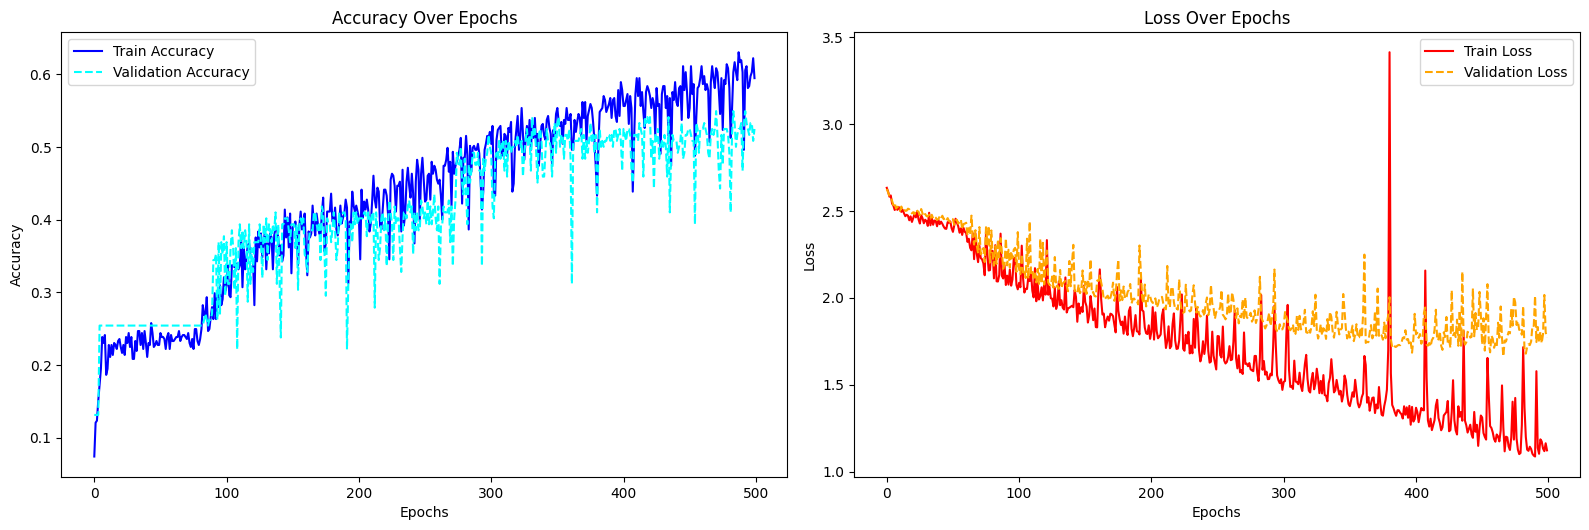

In [18]:
# Layout 2x2 para gráficos temporais
plt.figure(figsize=(16, 10))

# Gráfico de Acurácia
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Gráfico de Perda
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 5.3 Gráfico para comparação das métricas Recall X Precision X F1-Score

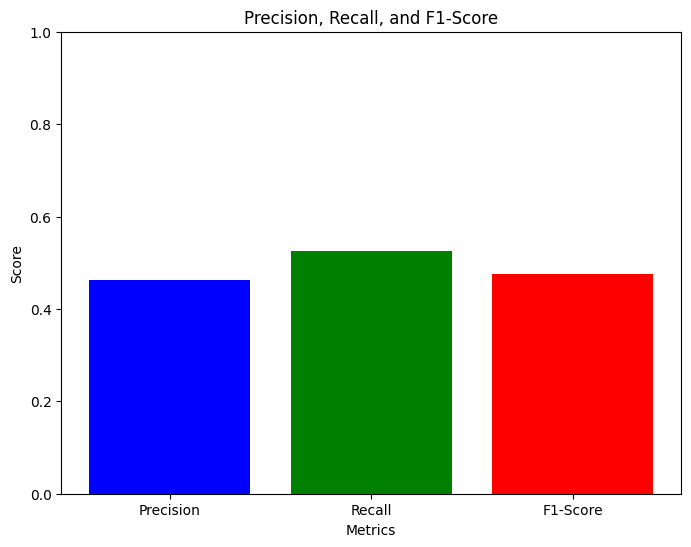

In [19]:
# Gráfico de Barras para as Métricas
metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()


## 5.4 Matriz de Confusão

A partir da matriz de confusão se evidencia que o modelo está muito específico, pois para algumas labels ele acerta quase sempre, enquanto as outras labels não acertam nenhuma.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


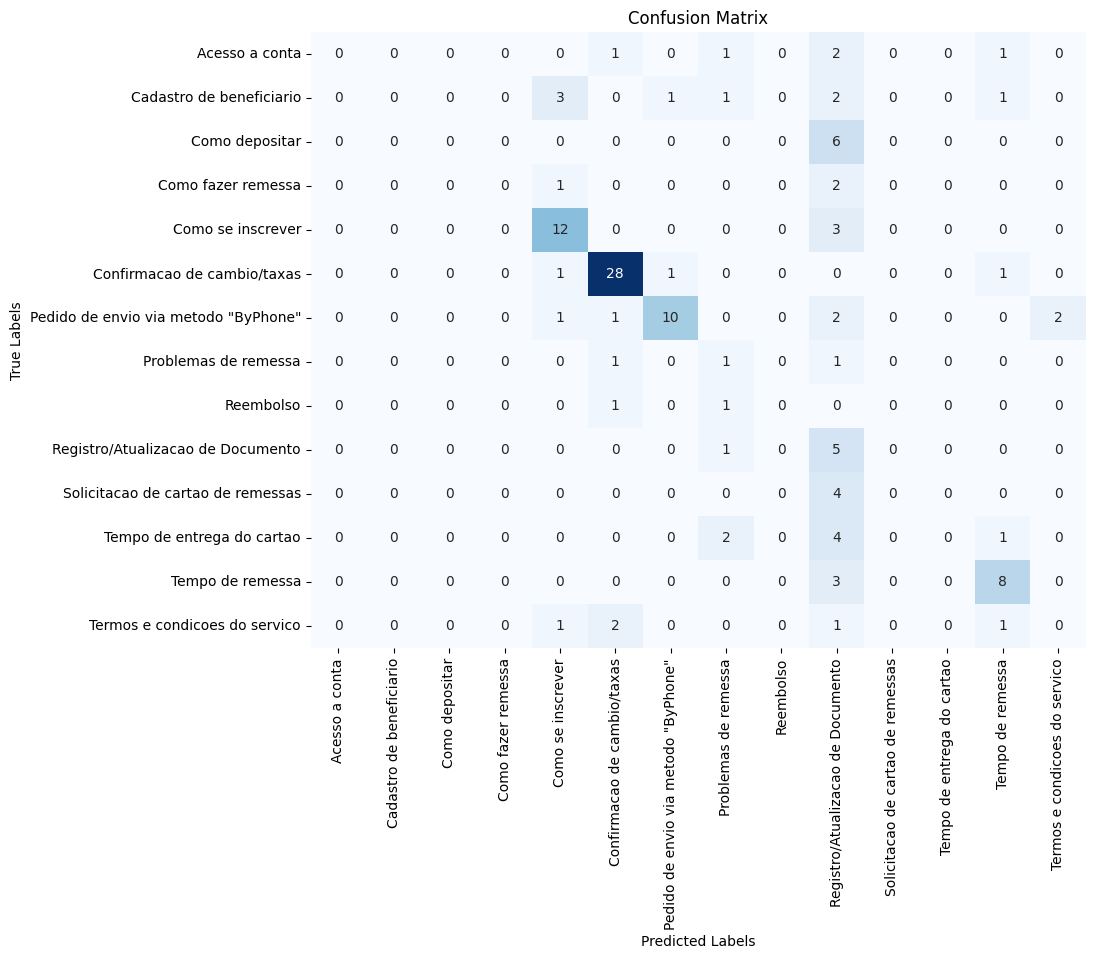

In [20]:
# Passo 1: Faça as previsões
predictions = model.predict(test_padded)
pred_labels = predictions.argmax(axis=1)
true_labels = test_labels_categorical.argmax(axis=1)

# Passo 2: Gere a matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Passo 3: Mapeamento de índices para rótulos
label_mapping = dict(enumerate(label_encoder.classes_))
labels = list(label_mapping.values())

# Passo 4: Visualize a matriz de confusão com rótulos de classes
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Ajuste a resolução e a margem
plt.show()

# 6. Performance

A CPU utiliza menos memória enquanto a GPU é muito mais rápida.

GPU
- TEMPO: 98.31 SEGUNDOS
- MEMORIA: 1144.51 MB

-----------

CPU
- TEMPO: 1243.25 SEGUNDOS
- MEMORIA: 1019.34MB

In [21]:
# Salvando o tempo de processamento e a memória utilizada
metrics_info = {
    "elapsed_time": elapsed_time,
    "memory_usage": memory_usage
}

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")


Elapsed Time: 98.31 seconds
Memory Usage: 1144.51 MB
